In [1]:
import pandas as pd
import seaborn as sns
from datetime import date
from collections import Counter
from sklearn import preprocessing
from sklearn.cluster import KMeans

sns.set(style='white', color_codes=True)

In [2]:
# Lê os dados do CSV e salva em duas variáveis
data_original = pd.read_csv('data.csv') # dados originais para facilitar visualização dos clusters no final
data = pd.DataFrame.copy(data_original) # dados que serão manipulados para a clusterização

In [3]:
data.head()

,ID,GEO_REFERENCIA,DATA_NASCIMENTO,PROFISSAO,GENERO,ESTADO_CIVIL,VALOR_01,VALOR_02,VALOR_03,VALOR_04,PERFIL
0,1,780,8/15/92,ANALISTA DE SISTEMAS,M,SOLTEIRO(A),342.86,342.86,428.57,28.57,A
1,2,35,2/24/90,SERVIDOR PÚBLICO ESTADUAL,F,SOLTEIRO(A),942.86,0.00,0.00,0.00,A
2,3,54,7/17/87,ANALISTA DE SISTEMAS,M,SOLTEIRO(A),2000.00,0.00,0.00,2857.14,A
3,4,35,4/27/88,BANCARIO E ECONOMIÁRIO,M,CASADO(A) COM BRASILEIRO(A) NATO(A),857.14,285.71,0.00,1428.57,A
4,5,883,12/10/71,SERVIDOR PÚBLICO MUNICIPAL,M,CASADO(A) COM BRASILEIRO(A) NATO(A),8615.39,0.00,0.00,47471.79,A


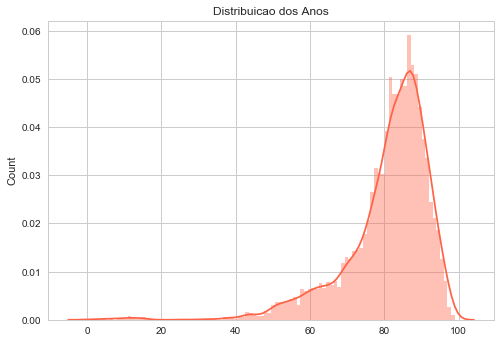

In [4]:
# Para transformar a data de nascimento em idade será necessário tratar os anos menores que 17 para
# decidir se são pessoas jovens ou pessoas centenárias...

nascimento_split = [int(x.split('/')[2]) for x in data['DATA_NASCIMENTO']]
#pd.Series(nascimento_split).value_counts()

sns.set_style("whitegrid")
sns.distplot(nascimento_split, bins=100, color='tomato')
sns.plt.title("Distribuicao dos Anos")
sns.plt.ylabel("Count")
sns.plt.show()

# Ao olhar a distribuição dos anos de nascimento percebemos que a população é, em geral, jovem.
# Portanto trataremos os anos menores que 17 como sendo da década de 2000 e não 1900.

In [5]:
# Cria coluna IDADE no lugar da coluna DATA_NASCIMENTO

def calculate_age(born):
    month, day, year = map(int, born.split('/'))
    # tratamento para o ano, pois está apenas com 2 casas decimais no CSV
    if year < 17:
        year += 2000
    else:
        year += 1900
    today = date.today()
    return today.year - year - ((today.month, today.day) < (month, day))

data_original['IDADE'] = map(calculate_age, data_original['DATA_NASCIMENTO'])
data['IDADE'] = map(calculate_age, data['DATA_NASCIMENTO'])

data = data.drop('DATA_NASCIMENTO', axis=1)

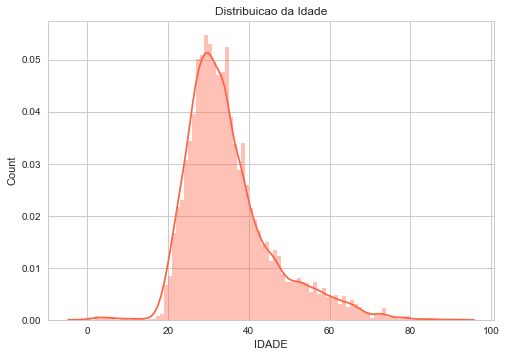

In [6]:
sns.set_style("whitegrid")
sns.distplot(data['IDADE'], bins=91, color='tomato')
sns.plt.title("Distribuicao da Idade")
sns.plt.ylabel("Count")
sns.plt.show()

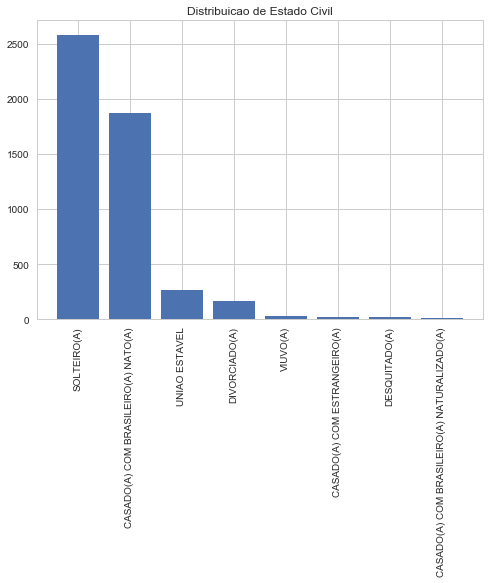

In [7]:
# Dando uma olhada na distribuição de estado civil é possível perceber que alguns valores aparecem muito pouco

counts = Counter(data['ESTADO_CIVIL'])
common = counts.most_common()
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)

sns.plt.title("Distribuicao de Estado Civil")
sns.plt.bar(sns.np.arange(nbars), number, tick_label=labels)
sns.plt.xticks(xrange(len(labels)), labels, rotation='vertical')
sns.plt.show()

In [8]:
data['ESTADO_CIVIL'].value_counts()

SOLTEIRO(A)                                    2584
CASADO(A) COM BRASILEIRO(A) NATO(A)            1870
UNIAO ESTAVEL                                   267
DIVORCIADO(A)                                   164
VIUVO(A)                                         35
CASADO(A) COM ESTRANGEIRO(A)                     20
DESQUITADO(A)                                    19
CASADO(A) COM BRASILEIRO(A) NATURALIZADO(A)      13
Name: ESTADO_CIVIL, dtype: int64

In [9]:
#SOLTEIRO(A)                                    2584
#CASADO(A) COM BRASILEIRO(A) NATO(A)            1870
#UNIAO ESTAVEL                                   267
#DIVORCIADO(A)                                   164
#VIUVO(A)                                         35
#CASADO(A) COM ESTRANGEIRO(A)                     20
#DESQUITADO(A)                                    19
#CASADO(A) COM BRASILEIRO(A) NATURALIZADO(A)      13

# Agrupo algumas categorias pois são parecidas e tem pouco exemplares de cada.

# Acredito que neste caso será melhor tratar, por exemplo, todos os tipos de "casados"
# como uma coisa só, pois não parece ter relevância considerar isoladamente os
# perfils "casados com brasileiros naturalizados" ou "casados com estrangeiros".

data['SOLTEIRO'] = (data['ESTADO_CIVIL'] == 'SOLTEIRO(A)')
data['CASADO'] = ((data['ESTADO_CIVIL'] == 'CASADO(A) COM BRASILEIRO(A) NATO(A)') | (data['ESTADO_CIVIL'] == 'CASADO(A) COM ESTRANGEIRO(A)') | (data['ESTADO_CIVIL'] == 'CASADO(A) COM BRASILEIRO(A) NATURALIZADO(A)'))
data['UNIAO_ESTAVEL'] = (data['ESTADO_CIVIL'] == 'UNIAO ESTAVEL')
data['DIVORCIADO'] = ((data['ESTADO_CIVIL'] == 'DIVORCIADO(A)') | (data['ESTADO_CIVIL'] == 'DESQUITADO(A)'))
data['VIUVO'] = (data['ESTADO_CIVIL'] == 'VIUVO(A)')

data = data.drop('ESTADO_CIVIL', axis=1)

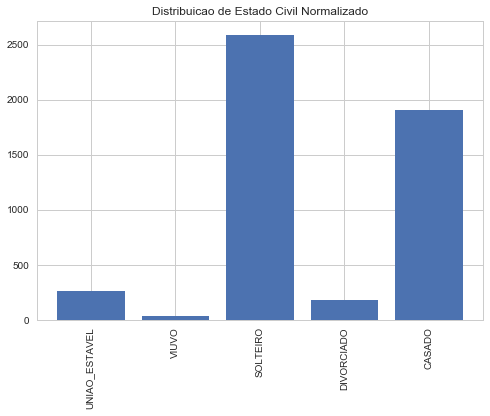

In [10]:
common = { 'SOLTEIRO' : data['SOLTEIRO'].sum(),
          'CASADO' : data['CASADO'].sum(),
         'UNIAO_ESTAVEL' : data['UNIAO_ESTAVEL'].sum(),
         'DIVORCIADO' : data['DIVORCIADO'].sum(),
         'VIUVO' : data['VIUVO'].sum() }
labels = common.keys()
number = common.values()
nbars = len(common)

sns.plt.title("Distribuicao de Estado Civil Normalizado")
sns.plt.bar(sns.np.arange(nbars), number, tick_label=labels)
sns.plt.xticks(xrange(len(labels)), labels, rotation='vertical')
sns.plt.show()

In [11]:
# Converte sexo e perfil para variáveis booleanas para a clusterização

data['GENERO_BOOL'] = (data['GENERO'] == 'M')
data['PERFIL_A'] = (data['PERFIL'] == 'A')
data['PERFIL_B'] = (data['PERFIL'] == 'B')
data['PERFIL_C'] = (data['PERFIL'] == 'C')
data['PERFIL_D'] = (data['PERFIL'] == 'D')

data = data.drop(['GENERO', 'PERFIL'], axis=1)

In [12]:
# Remove colunas que não serão utilizadas
data = data.drop(['GEO_REFERENCIA', 'PROFISSAO'], axis=1)
data.head()

,ID,VALOR_01,VALOR_02,VALOR_03,VALOR_04,IDADE,SOLTEIRO,CASADO,UNIAO_ESTAVEL,DIVORCIADO,VIUVO,GENERO_BOOL,PERFIL_A,PERFIL_B,PERFIL_C,PERFIL_D
0,1,342.86,342.86,428.57,28.57,24,True,False,False,False,False,True,True,False,False,False
1,2,942.86,0.00,0.00,0.00,27,True,False,False,False,False,False,True,False,False,False
2,3,2000.00,0.00,0.00,2857.14,29,True,False,False,False,False,True,True,False,False,False
3,4,857.14,285.71,0.00,1428.57,29,False,True,False,False,False,True,True,False,False,False
4,5,8615.39,0.00,0.00,47471.79,45,False,True,False,False,False,True,True,False,False,False


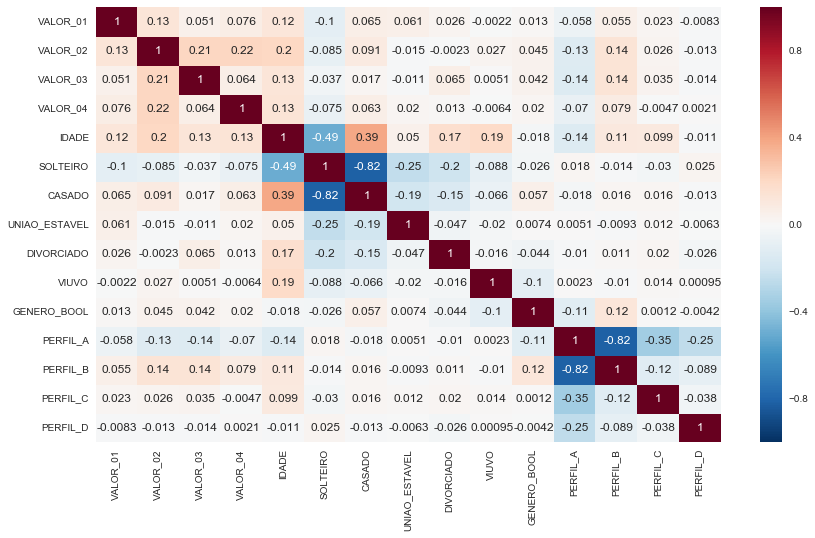

In [13]:
# Dando uma olhada geral na correlação entre as variáveis é possível perceber que
# as colunas de valores tem alto grau de correlação entre si, assim como a idade e
# o estado civil estão relacionados.

# O mapa de calor também indica correlação alta entre as variáveis "auto-excludentes"
# que foram criadas nas etapas anteriores, pois se uma pessoa é casada ela obviamente
# não é solteira. Então é importante não levar em consideração estas constatações.

sns.plt.figure(figsize=(14,8))
sns.heatmap(data.drop(['ID'], axis=1).corr(), annot=True)
sns.plt.show()

In [14]:
# Normaliza features para rodar algoritmo de clusterização

data_scaled = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform( data.drop('ID', axis=1).values ))
data_scaled.columns = data.columns.values[1:]
data_scaled

C:\Users\LCalzavara\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,VALOR_01,VALOR_02,VALOR_03,VALOR_04,IDADE,SOLTEIRO,CASADO,UNIAO_ESTAVEL,DIVORCIADO,VIUVO,GENERO_BOOL,PERFIL_A,PERFIL_B,PERFIL_C,PERFIL_D
0,0.000857,0.000120,0.000300,0.000042,0.263736,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.002357,0.000000,0.000000,0.000000,0.296703,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.005000,0.000000,0.000000,0.004167,0.318681,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.002143,0.000100,0.000000,0.002083,0.318681,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.021538,0.000000,0.000000,0.069230,0.494505,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,0.001429,0.000144,0.000000,0.000083,0.329670,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,0.000857,0.000000,0.000000,0.000000,0.296703,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,0.003571,0.000000,0.000000,0.000000,0.285714,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,0.001071,0.000000,0.000000,0.000000,0.461538,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
9,0.007143,0.088625,0.000000,0.112083,0.395604,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [15]:
# Rodando algoritmo K-Means inicialmente com 4 clusters

# Este algoritmo foi escolhido por ser um algoritmo de propósito geral muito utilizado no mercado

model = KMeans(n_clusters=4).fit(data_scaled)

In [16]:
data['CLUSTER'] = model.predict(data_scaled)
data_original['CLUSTER'] = data['CLUSTER']

In [17]:
data_original['CLUSTER'].value_counts()

0    1834
2    1655
1     896
3     587
Name: CLUSTER, dtype: int64

In [18]:
cluster_0 = data_original.loc[data_original['CLUSTER'] == 0]
cluster_1 = data_original.loc[data_original['CLUSTER'] == 1]
cluster_2 = data_original.loc[data_original['CLUSTER'] == 2]
cluster_3 = data_original.loc[data_original['CLUSTER'] == 3]

In [19]:
# Estado civil de cada cluster

print cluster_0['ESTADO_CIVIL'].value_counts()
print '---'
print cluster_1['ESTADO_CIVIL'].value_counts()
print '---'
print cluster_2['ESTADO_CIVIL'].value_counts()
print '---'
print cluster_3['ESTADO_CIVIL'].value_counts()
print '---'

SOLTEIRO(A)    1834
Name: ESTADO_CIVIL, dtype: int64
---
SOLTEIRO(A)      750
UNIAO ESTAVEL     77
DIVORCIADO(A)     47
DESQUITADO(A)     12
VIUVO(A)          10
Name: ESTADO_CIVIL, dtype: int64
---
CASADO(A) COM BRASILEIRO(A) NATO(A)            1292
UNIAO ESTAVEL                                   190
DIVORCIADO(A)                                   117
VIUVO(A)                                         25
CASADO(A) COM ESTRANGEIRO(A)                     13
CASADO(A) COM BRASILEIRO(A) NATURALIZADO(A)      11
DESQUITADO(A)                                     7
Name: ESTADO_CIVIL, dtype: int64
---
CASADO(A) COM BRASILEIRO(A) NATO(A)            578
CASADO(A) COM ESTRANGEIRO(A)                     7
CASADO(A) COM BRASILEIRO(A) NATURALIZADO(A)      2
Name: ESTADO_CIVIL, dtype: int64
---


In [20]:
# Genero de cada cluster

print cluster_0['GENERO'].value_counts()
print '---'
print cluster_1['GENERO'].value_counts()
print '---'
print cluster_2['GENERO'].value_counts()
print '---'
print cluster_3['GENERO'].value_counts()
print '---'

M    1346
F     488
Name: GENERO, dtype: int64
---
M    746
F    150
Name: GENERO, dtype: int64
---
M    1261
F     394
Name: GENERO, dtype: int64
---
M    512
F     75
Name: GENERO, dtype: int64
---


In [21]:
# Perfil de cada cluster

print cluster_0['PERFIL'].value_counts()
print '---'
print cluster_1['PERFIL'].value_counts()
print '---'
print cluster_2['PERFIL'].value_counts()
print '---'
print cluster_3['PERFIL'].value_counts()
print '---'

A    1834
Name: PERFIL, dtype: int64
---
B    666
C    143
D     87
Name: PERFIL, dtype: int64
---
A    1655
Name: PERFIL, dtype: int64
---
B    439
C    102
D     46
Name: PERFIL, dtype: int64
---


In [22]:
# Top 10 profissões de cada cluster

print cluster_0['PROFISSAO'].value_counts().head(10)
print '---'
print cluster_1['PROFISSAO'].value_counts().head(10)
print '---'
print cluster_2['PROFISSAO'].value_counts().head(10)
print '---'
print cluster_3['PROFISSAO'].value_counts().head(10)
print '---'

ESTUDANTE                                264
ANALISTA DE SISTEMAS                     234
ENGENHEIRO                               155
ADMINISTRADOR                            143
AUXILIAR DE ESCRITÓRIO E ASSEMELHADOS    124
AUTÔNOMO                                 106
SERVIDOR PÚBLICO FEDERAL                  84
SERVIDOR PÚBLICO ESTADUAL                 69
EMPRESÁRIO                                57
MÉDICO                                    42
Name: PROFISSAO, dtype: int64
---
ADMINISTRADOR                111
ENGENHEIRO                   105
ANALISTA DE SISTEMAS          90
ESTUDANTE                     85
SERVIDOR PÚBLICO FEDERAL      55
AUTÔNOMO                      43
MÉDICO                        35
BANCARIO E ECONOMIÁRIO        31
ADVOGADO                      29
SERVIDOR PÚBLICO ESTADUAL     28
Name: PROFISSAO, dtype: int64
---
ANALISTA DE SISTEMAS                       195
ENGENHEIRO                                 165
ADMINISTRADOR                              121
SERVIDOR PÚ

In [23]:
# Idade média de cada cluster

print cluster_0['IDADE'].mean()
print '---'
print cluster_1['IDADE'].mean()
print '---'
print cluster_2['IDADE'].mean()
print '---'
print cluster_3['IDADE'].mean()
print '---'

29.0468920393
---
33.7622767857
---
39.4132930514
---
42.601362862
---


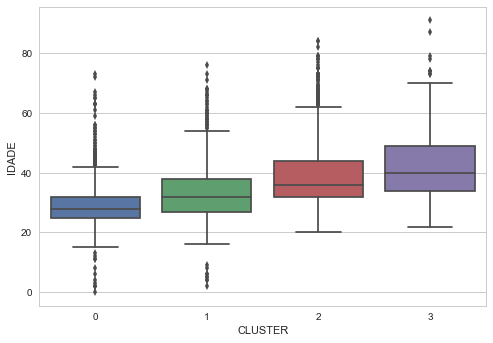

In [24]:
# Boxplot da idade por cluster

sns.boxplot('CLUSTER', 'IDADE', data=data_original)
sns.plt.show()

In [25]:
# Valor_01 de cada cluster

print cluster_0['VALOR_01'].mean()
print '---'
print cluster_1['VALOR_01'].mean()
print '---'
print cluster_2['VALOR_01'].mean()
print '---'
print cluster_3['VALOR_01'].mean()
print '---'

1230.3126554
---
2122.28004464
---
2412.20685801
---
3248.20391823
---


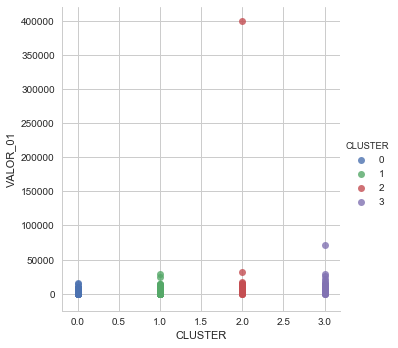

In [33]:
sns.lmplot('CLUSTER', 'VALOR_01', data=data_original, hue='CLUSTER', fit_reg=False)
sns.plt.show()

In [34]:
# Valor_02 de cada cluster

print cluster_0['VALOR_02'].mean()
print '---'
print cluster_1['VALOR_02'].mean()
print '---'
print cluster_2['VALOR_02'].mean()
print '---'
print cluster_3['VALOR_02'].mean()
print '---'

5613.22603599
---
25619.0224107
---
16900.9117221
---
53574.308109
---


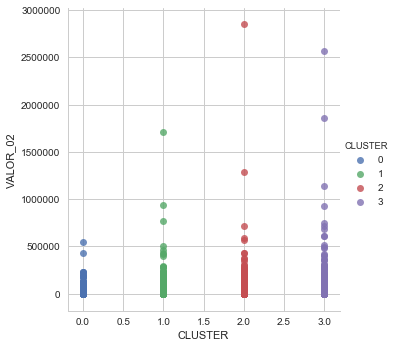

In [35]:
sns.lmplot('CLUSTER', 'VALOR_02', data=data_original, hue='CLUSTER', fit_reg=False)
sns.plt.show()

In [36]:
# Valor_03 de cada cluster

print cluster_0['VALOR_03'].mean()
print '---'
print cluster_1['VALOR_03'].mean()
print '---'
print cluster_2['VALOR_03'].mean()
print '---'
print cluster_3['VALOR_03'].mean()
print '---'

362.79802072
---
11445.2443862
---
1481.71480967
---
13185.4872743
---


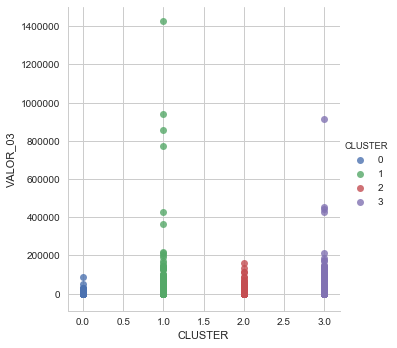

In [37]:
sns.lmplot('CLUSTER', 'VALOR_03', data=data_original, hue='CLUSTER', fit_reg=False)
sns.plt.show()

In [38]:
# Valor_04 de cada cluster

print cluster_0['VALOR_04'].mean()
print '---'
print cluster_1['VALOR_04'].mean()
print '---'
print cluster_2['VALOR_04'].mean()
print '---'
print cluster_3['VALOR_04'].mean()
print '---'

2533.9823446
---
5969.14960938
---
5569.30585498
---
9968.62270869
---


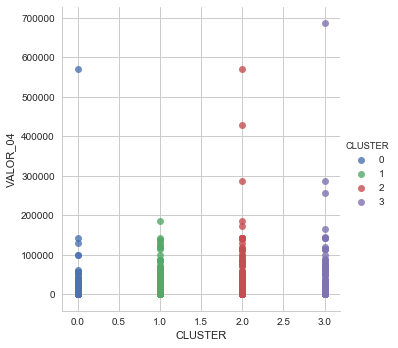

In [39]:
sns.lmplot('CLUSTER', 'VALOR_04', data=data_original, hue='CLUSTER', fit_reg=False)
sns.plt.show()

#### Baseado nas informações encontradas é possível definir os 4 clusters como:

Cluster 0: solteiros, perfil A, entre 25 e 35 anos, cluster com piores valores (provavelmente renda menor)

Cluster 1: solteiros, perfis B C D, entre 30 e 37 anos, cluster com valores na segunda posição

Cluster 2: não-solteiros, perfil A, entre 35 e 45 anos, cluster com valores na terceira posição

Cluster 3: não-solteiros, perfils B C D, acima de 40 anos, cluster com maiores valores (provavelmente a maior renda)